In [2]:
# update data
!rm -rf COVID-19
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 14751, done.
remote: Total 14751 (delta 0), reused 0 (delta 0), pack-reused 14751
Receiving objects: 100% (14751/14751), 47.18 MiB | 4.08 MiB/s, done.
Resolving deltas: 100% (7091/7091), done.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [5]:
df[(df['Country/Region']=='US') & ((df['Province/State'].isna()) | (df['Province/State']=='US'))]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20


In [6]:
def __split_data(df, nation):

    idx_start = 4

    df_n = df[(df['Country/Region']==nation) & ((df['Province/State'].isna()) | (df['Province/State']==nation))]
    
    n = df_n.shape[0]
    
    X = []
    y = []
    
    for i in range(0,n):
    
        X_t = np.asarray([datetime.strptime(col, '%m/%d/%y').timestamp() for col in df.columns[idx_start:]])
        y_t = df_n.values[i][idx_start:]

        idx = 0
        ii = [ i for i,y in enumerate(y_t) if y<100]
        if len(ii)>0:
            idx = max( ii )

        X_t = X_t[idx:]
        y_t = y_t[idx:]
        
        first_day = min(X_t)

        # renoramlize
        SEC_PER_DAY=24*60*60
        X_t = np.asarray([ (x - first_day)/SEC_PER_DAY for x in X_t])
      
        
        X.append(X_t)
        y.append(y_t)

    return np.asarray(X), np.asarray(y), df_n['Province/State'].values

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

def __build_model(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                      ('linear', ElasticNet(fit_intercept=False, max_iter=10000))])

    return model

def __evaluate_model(X_train, y_train, model):
      
    # predicting on training data-set
    y_train_predicted = model.predict(X_train)
    
    
    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)
    mape = np.mean(np.abs((y_train - y_train_predicted) / y_train)) * 100


    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("MAPE score of training set is {}".format(mape))

    return mape, rmse_train, r2_train

In [49]:
def predict_and_plot(df, nation, population, next_days, color):
    
    DEGREE=3

    X_train_l, y_train_l, provinces = __split_data(df, nation)

    n = X_train_l.shape[0]
    

    for i, p in enumerate(provinces):
        
        X_train = X_train_l[i] 
        y_train = y_train_l[i]
        
        X_train =X_train[0:-1]
        y_train = y_train[1:] - y_train[0:-1]

        last_day = max(X_train)
        
        if str(p)=='nan':
            p='all'
        else:
            p = str(p)
        
        plt.plot(X_train, y_train / population,'*', label=nation + ' ' + p + ' actual',c=color, linewidth=3.0)
    
        X_test = np.asarray([ i +last_day for i in range(0,next_days)])
        
        model = __build_model(DEGREE)
        model.fit(X_train.reshape(-1, 1)  , y_train / population)
        y_test_predict_u = model.predict(X_test.reshape(-1, 1))
        
        model = __build_model(DEGREE+1)
        model.fit(X_train.reshape(-1, 1) , y_train / population)
        y_test_predict_l = model.predict(X_test.reshape(-1, 1))
        
        y_test_predict = y_test_predict_u/2 + y_test_predict_l/2
        
        #y_test_predict_l, y_test_predict_u = y_test_predict - y_test_predict*mape/200, y_test_predict + y_test_predict*mape/200
        
        # show predicted data
        plt.plot(X_test, y_test_predict,':',c=color, linewidth=3.0)
        plt.fill_between(X_test, y_test_predict_l, y_test_predict_u, color=color, alpha=0.3, label= nation + ' predicted')
        
        print('current day ', nation, p,":", y_test_predict_u[0] * population, y_train[-1])
        print('next day ', nation, p,":", y_test_predict_u[1]* population)

In [50]:
population_by_nation = {'Italy': 60.480,
                        'France': 66.890,
                        'Spain':46.600,
                         'Japan':126.800,
                         'Germany': 82.790,
                         'Norway': 5.368,
                         'Belgium': 11.400,
                         'Greece': 10.740}
population_by_nation = {'Italy': 60.480,'Germany': 82.790,'France': 66.890,'Spain':46.600}

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1622.943346473247, tolerance: 2.480278363917584
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4244229467601599, tolerance: 0.2000725212934636
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.93950451764249, tolerance: 0.9609075503324799
  positive)


current day  Italy all : 3999.3748884781166 3526
next day  Italy all : 4394.1559055854505
current day  Germany all : 1912.4170022653066 1985
next day  Germany all : 2283.3239376901715
current day  France France : 1322.5268884698537 1019
next day  France France : 1521.449445394175
current day  Spain all : 2084.448620850748 1806
next day  Spain all : 2310.906153123441


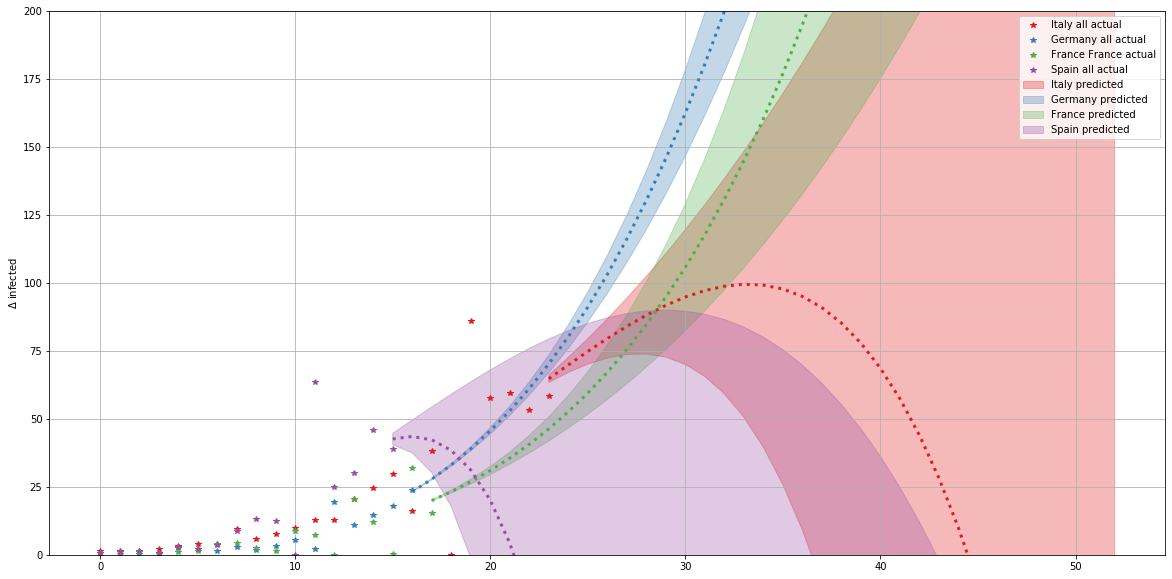

In [54]:
from matplotlib.cm import get_cmap

name = "Set1"
cmap = get_cmap(name)
COLORS =  cmap.colors


def predict_and_plot_all(df, population_by_nation, next_days):
    plt.figure(figsize=(20,10))
    for i,nation in enumerate(population_by_nation):
        #print("--\n",nation)
        population = population_by_nation[nation]
        predict_and_plot(df, nation,population, next_days, color = COLORS[i])
    
    plt.ylim(0, 200)
    plt.ylabel('$\Delta$ infected')
    plt.legend()
    plt.grid()
    plt.show()
    
predict_and_plot_all(df, population_by_nation, 30)